# Analyse de l'accessibilité piétonnière avec Python

Nous allons reproduire les [analyses de l'article de Gispo Ltd](https://gispofinland.medium.com/analysing-urban-walkability-using-openstreetmap-and-python-33815d045204). Cet article traite de l'évaluation de l'accessibilité piétionnière dans la ville. Il met à disposition son code dans [ce repo Github](https://github.com/eemilhaa/walkability-analysis). Il prend l'exemple de la Finlande, mais nous allons prendre un exemple en France, la ville de Lyon. L'idée est d'utiliser des outils et données libres, afin de réaliser une analyse en deux partie :

- la mesure de l'accessibilité globale via la densité d'intersection,
- la mesure de l'accessibilité des équipements au sein d'une ville.

Le sujet de l'accessibilité piétonne est associé à d'autres thématiques :
- présence d'espace vert,
- qualité de l'air,
- pollution par voiture etc.

## 1/ Cadre théorique

### 1.1/ La densité des intersections

La densité d'intersection est un indicateur sur l'interconnexion du réseau. Une corrélation positive entre la **densité d'intersection et l'usage de la marche comme principal mode de transport** a été démontrée dans [cet article](https://www.tandfonline.com/doi/abs/10.1080/01944361003766766). Ce qui renforce l'intérêt de cet indicateur dans la compréhension de l'accessibilité de l'espace urbain.

**Remarque**: au cours de son explication, l'analyste indique avoir réalisé des traitements "grossièrement", sans tenir compte de chaque spécificité. Par exemple, quand deux rues fusionnent en une à des points différents, cela peut représenter deux intersections. Ce qui revient à sur-évaluer le nombre d'intersection sur cette rue fusionnée. On peut donc dire qu'il s'agit surtout de donner une idée globale, d'une situation, sans aller trop dans le détail, afin de trouver le juste milieu entre qualité et rapidité.


MultiDiGraph with 25168 nodes and 73550 edges


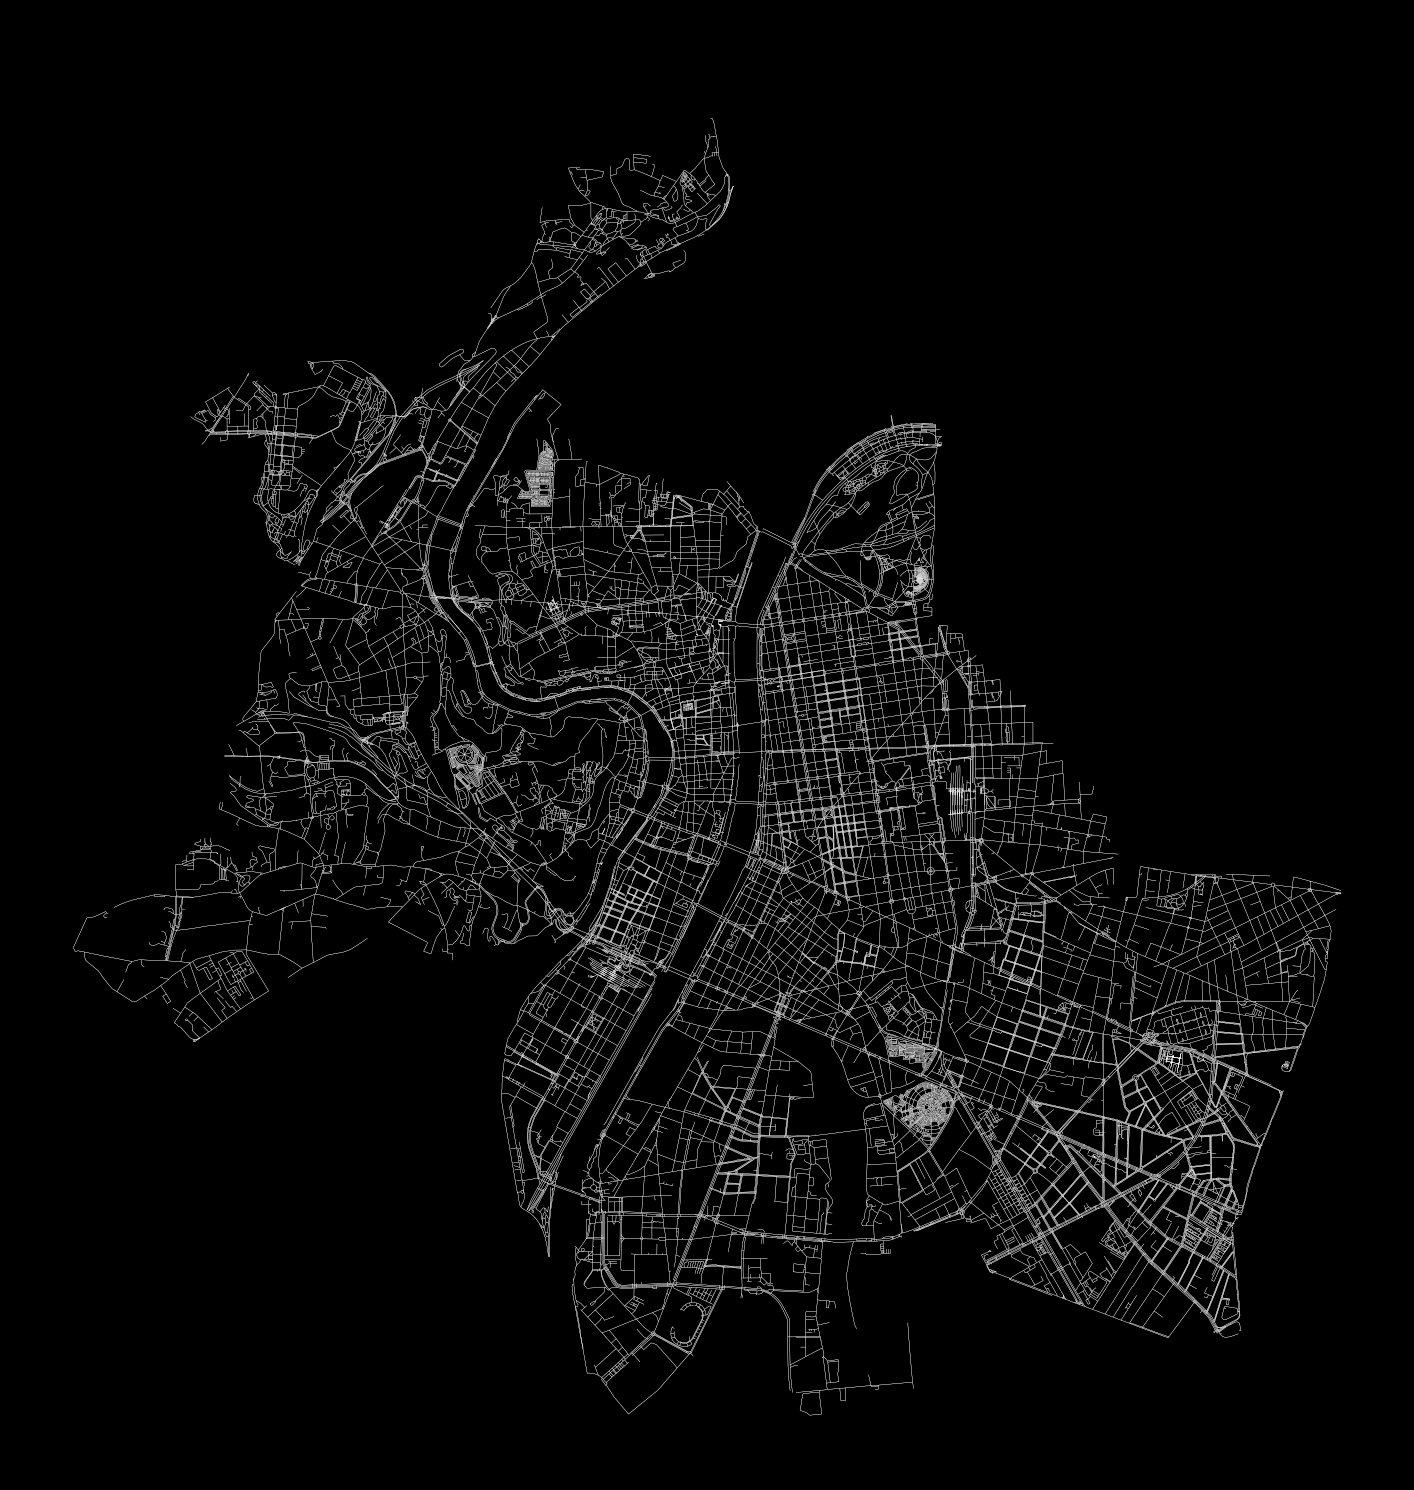

In [14]:
## import des modules

import osmnx # module OSM network X pour obtenir des données.
import matplotlib.pyplot as plt
import pandas
import os
os.environ["USE_PYGEOS"] = "0"
import geopandas
import seaborn

## Définir une ville
nom_ville = "lyon, france"
crs_metrique = 2154 #Projecion France métropolitaine.
crs_folium = 4326 #Projection mondiale.

#Obtenir le réseau piéton :
graph = osmnx.graph_from_place(query=nom_ville, network_type="walk")
#Puis re-projeter :
graph = osmnx.projection.project_graph(graph, to_crs=crs_metrique)
print(graph) # noeuds = 25 168 et lignes = 73 550.

#Ensuite, simplifier le graphe :

graph_simplifie = osmnx.simplification.consolidate_intersections(
    graph,
    tolerance=5, #valeur par défaut
    rebuild_graph=True, #Reconstruire à partir de la simplification.
    dead_ends=False,
    reconnect_edges=True# Reconnecter le graphe

)
#Consolider = stabiliser.
# Description de la méthode osmnx.simplification.consolidate_intersections() :
#
# Permet de simplifier la géométrie d'un réseau en réduisant le nombre de
# noeuds et en reconnectant les arêtes en conséquence. Les noeuds sont 
# réduits en fonction de leur distance. Lorsqu'ils sont proches : ils 
# forment un cluster. OSMnx récupère le centroïde de ce cluster. Pour
# que la fonction réalise bien la simplification, le graphe doit être 
# projeté en unité métrique (mètre par exemple).

# Convertir en geodataframe pour manipuler :
noeuds, aretes = osmnx.graph_to_gdfs(graph)
noeud_s, arete_s = osmnx.graph_to_gdfs(graph_simplifie)

# Afficher les résultats :
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off() # Masquer les axes.
ax.set_aspect("equal")
fig.set_facecolor("black")

aretes.plot(
    ax=ax,
    color="white",
    linewidth=0.2
)
plt.title("Réseau piéton de Lyon, non simplifié", fontsize=30)
plt.tight_layout()



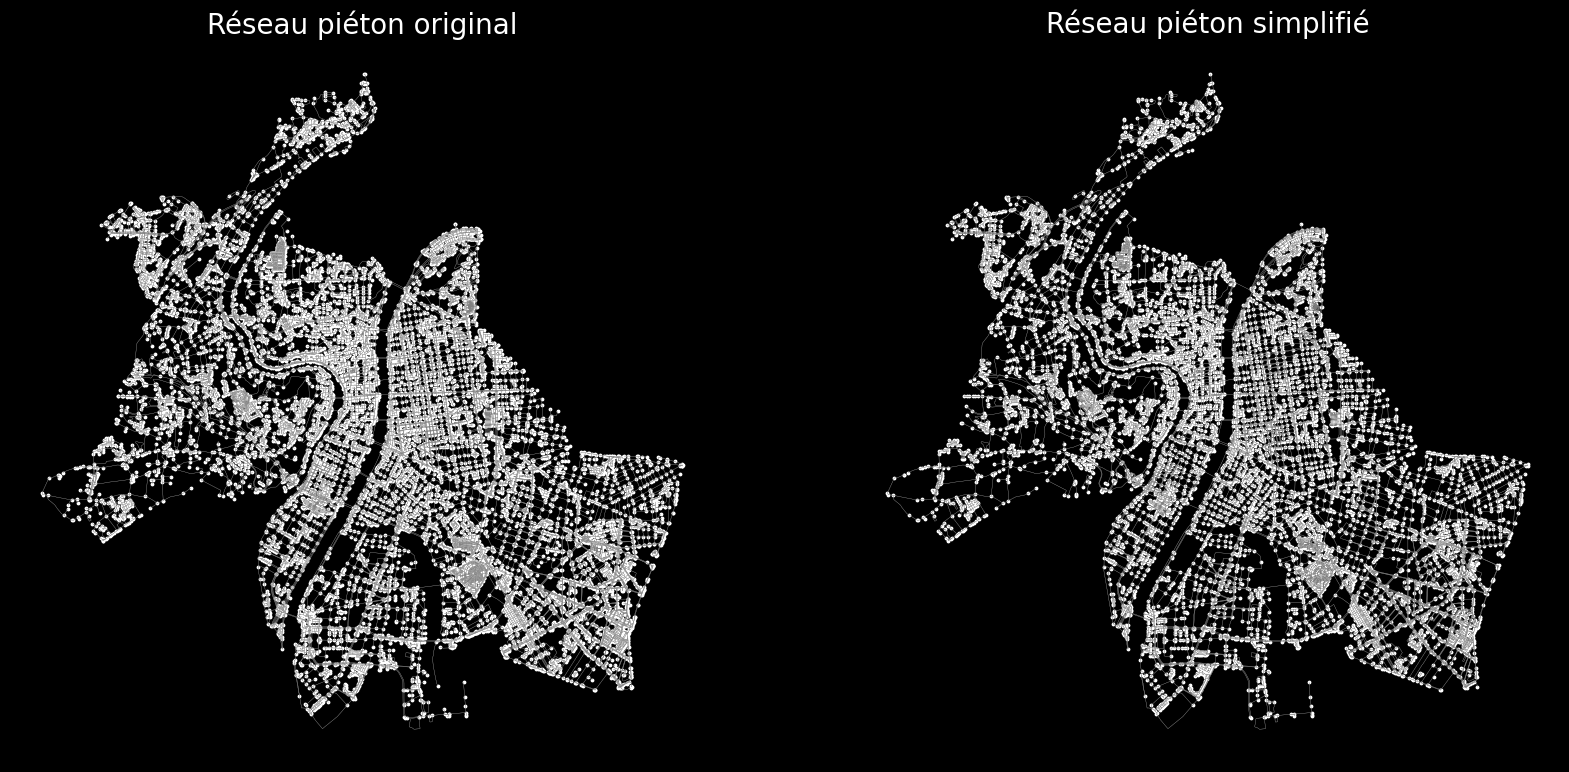

In [32]:
#Comparer les deux graphes :

aretes_col = [0.5, 0.5, 0.5]
noeuds_col = "white"
aretes_epaisseur = 0.2
points = 3

# Paramétrer la zone de dessin :
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].set_aspect("equal") ; ax[0].set_axis_off()
ax[1].set_aspect("equal") ; ax[1].set_axis_off()
fig.set_facecolor("black")

# Afficher le graph original :
aretes.plot(ax=ax[0], color=aretes_col, linewidth=aretes_epaisseur)
noeuds.plot(ax=ax[0], color=noeuds_col, markersize=points)

# Afficher le graph simplifié :
arete_s.plot(ax=ax[1], color=aretes_col, linewidth=aretes_epaisseur)
noeud_s.plot(ax=ax[1], color=noeuds_col, markersize=points)

# Titres :
ax[0].set_title(label="Réseau piéton original", loc="center",
                color="white",
                fontdict={
                    "fontsize":20,
                    "verticalalignment" : "baseline"
                })
ax[1].set_title(label="Réseau piéton simplifié", loc="center",
                color="white",
                fontdict={
                    "fontsize":20,
                    "verticalalignment" : "baseline"
                })

In [33]:
# Consultons les statistiques des deux graphes.

stats_graphs = {
    "Nom":["Original", "Simplifié"],
    "Nb_noeuds":[len(noeuds), len(noeud_s)],
    "Nb_aretes":[len(aretes), len(arete_s)]
}
stats_graphs = pandas.DataFrame.from_dict(data=stats_graphs)
stats_graphs

,Nom,Nb_noeuds,Nb_aretes
0,Original,25168,73550
1,Simplifié,11638,43346


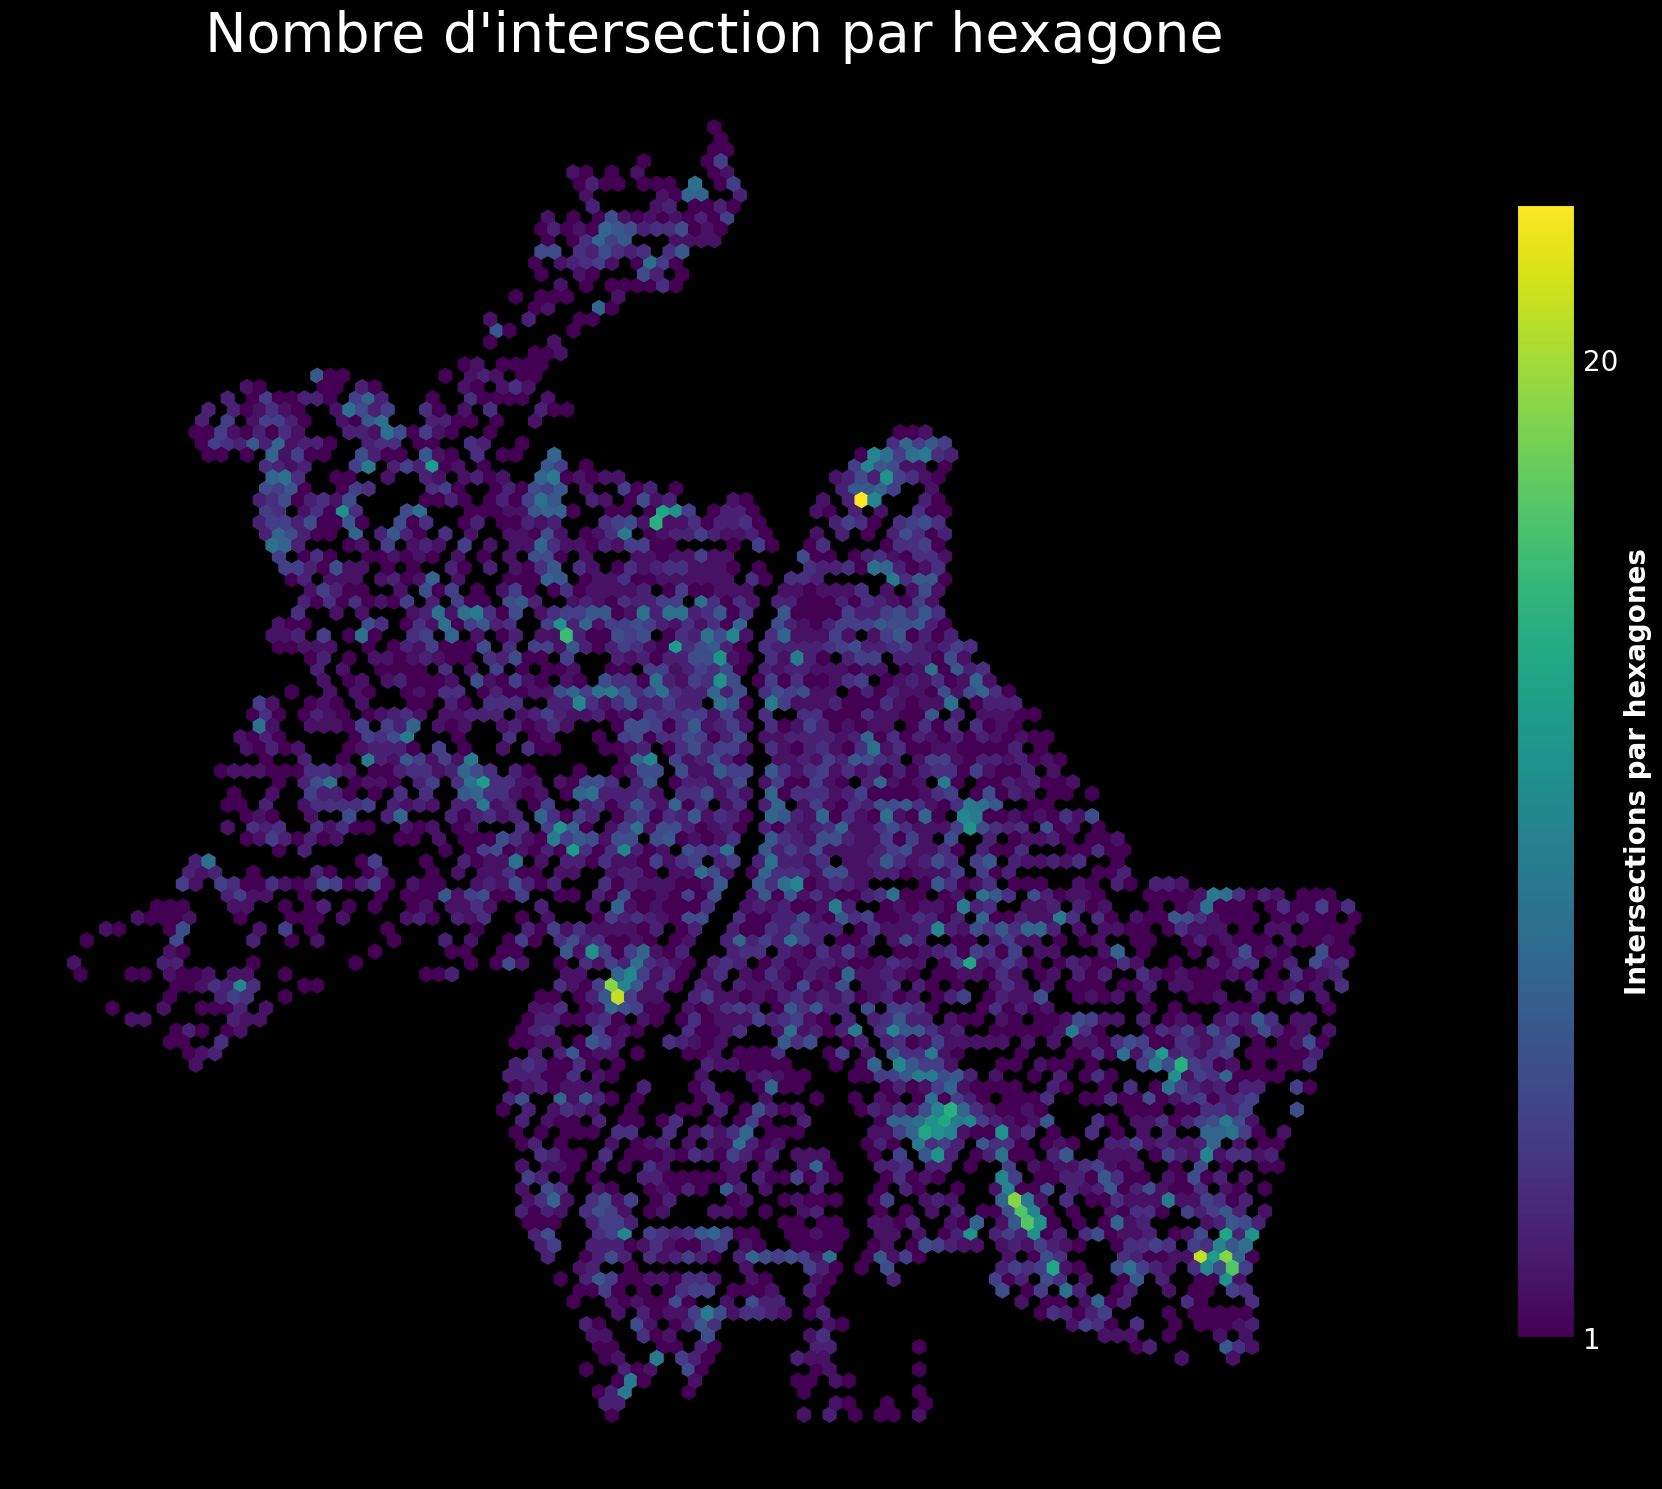

In [44]:
# Compter le nombre de noeuds dans des espaces délimités.
# Comme d'habitude en géographie, on cherche à caractériser les espaces.
# Pour caractériser et comparer des espaces, il faut les rendre comparable.
# Lorsqu'on compare deux espaces d'un point de vue de la densité, 
# par exemple, on s'assure de comparer des surfaces de même taille.
# Idéalement, on utilise un découpage spatial sous forme de grille.
# Ici, nous allons faire un découpage sous forme d'hexagon.
COLOR = "white" # Variable globale
plt.rcParams["text.color"] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Affichage :
fig, ax = plt.subplots(figsize=(20, 15))
ax.set_axis_off()
ax.set_aspect("equal")
fig.set_facecolor("black")

ax.set_title(label="Nombre d'intersection par hexagone", loc="center",
                color="white",
                fontdict={
                    "fontsize":40,
                    "verticalalignment" : "baseline"
                })

# A partir du nuage de points des noeuds, créer un pavage hexagonal :

hb = ax.hexbin(
    x=noeud_s["x"],
    y=noeud_s["y"],
    #gridsize=75, #pas
    cmap="viridis",
    mincnt=1, #nb de points minimum à considérer.
    #vmax=100
)

map = plt.colorbar(hb, ax=ax, shrink=0.8, ticks=[1, 20, 40, 60, 80, 100])
map.ax.tick_params(color='none', labelsize=20)
#map.ax.set_yticklabels(['1', '20', '40', '60', '80', '>= 100'])
map.set_label('Intersections par hexagones', fontsize=20, fontweight='bold')

# Tight layout
plt.tight_layout()